## S4: 
Gene Synteny Plot

Sort similarity (by RdRp)

Gene_color_palette (new_codes_needed, curated with accession-annotation)

Plot

Check: Step1:plot_synteny.py

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
from matplotlib import colormaps
from typing import List,Tuple
from matplotlib.axes import Axes
import seaborn as sns
import pandas as pd
from dna_features_viewer import GraphicFeature, GraphicRecord
from foreground import get_foreground 

In [2]:
family_dict={
    'zika':'Flaviviridae',
    'ebola':'Filoviridae',
    'measles':'Paramyxoviridae'
}
ref_genome_dict={
    'zika':'ZIKV||AY632535',
    'ebola':'EBOV||AF086833',
    'measles':'MeV||AB016162'
}
ref_accession_dict={
    'zika':'PF00972',
    'ebola':'PF00946',
    'measles':'PF00946'
}

In [3]:
def hide_axes(ax:Axes,genome_start_pos:int,genome_end_pos:int,sequence_length=42000):
    #hack: since I don't~~~~~ didn't know how to erase axes around coordinates, draw a white box over them.
    # is that a ugly hack? yes. does it render well? also yes
    ax.add_patch(
     patches.Rectangle(
        (-100, -0.25),
        genome_start_pos,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 
    ax.add_patch(
     patches.Rectangle(
        (genome_end_pos, -0.25),
        sequence_length+100,
        0.5,
        fill=True,      # remove background
        facecolor='white'
     ) ) 
    

def parse_diamond(matchfile:str='diamond-matches.tsv')->pd.DataFrame:
    '''
    matchfile:
        output of diamond blastp
        with '--header', 'verbose', 
        and 'tsv' suffix
    '''
    head_lines=open(matchfile,'r').readlines()[2].strip().split(': ')[1]
    diamond_aligns=pd.read_csv(matchfile,skiprows=3,names=head_lines.split(', '),delim_whitespace=True)
    return diamond_aligns


In [4]:
from pathlib import Path
def get_identities(fasta_path:str):
    '''
    from diamond tsv
    to df of ['domain','virus','identity']
    '''
    o_dict={}
    _={}
    _['domain'],_['virus'],_['identity']=[],[],[]
    for i in Path(fasta_path).iterdir():
        if i.suffix=='.tsv':
            stem=i.stem.replace('-match','')
            diamond=parse_diamond(i.absolute())
            o_dict[stem]={i:j for i,j in zip(diamond['Subject ID'],diamond['Percentage of identical matches'])}
            for idx,s in diamond.iterrows():
                _['domain'].append(stem)
                _['virus'].append(s['Subject ID'])
                _['identity'].append(s['Percentage of identical matches'])
    identities=pd.DataFrame(_)
    # identities.columns
    return o_dict,identities

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from typing import Callable
def cal_lr(x,y,refx=np.linspace(1,100,100)):
    lr=LinearRegression()
    x_=np.array(x).reshape(-1,1)
    y_=np.array(y).reshape(-1,1)
    reg=lr.fit(X=x_,y=y_)
    r2=reg.score(x_,y_)
    coef=reg.coef_[0][0]
    intercept=reg.intercept_[0]
    
    predy=reg.predict(refx.reshape(-1,1))
    sel=(predy>0) & (predy<100)
    
    reg_x=refx[sel.reshape(-1)].reshape(-1)
    reg_y=predy[sel].reshape(-1)
    
    return (
        coef,intercept,r2,
        reg_x,reg_y,
    )
    
def model_function(x:np.ndarray, a:float)->np.ndarray:
    return 2 ** (x ** a)-1

def cal_cur(x,y,model_function:Callable[[np.ndarray,float], np.ndarray]=model_function,p0=[2.0],refx=np.linspace(1,100,100)):
    # lr=LinearRegression()
    x_=np.array(x)/100
    y_=np.array(y)/100
    opt_paras, _ = curve_fit(model_function, x_, y_, p0=p0)
    
    rmsd=((y_-model_function(x_, *opt_paras))**2).mean()
    # a_optimal = optimal_parameters
    predy = model_function(refx/100, *opt_paras)
    sel=(predy>=0) & (predy<=1)

    reg_x=refx[sel]
    reg_y=predy[sel]*100

    return (
        opt_paras,rmsd,
        reg_x,reg_y,
    )

In [6]:
def get_lr_cohort(identities_dict:dict,
                  ref_genome:str,
                  ref_accession:str):
    '''use `identity_dict` from `get_identities`'''
    o_dict={}
    for accession,d in identities_dict.items():
            # if accession!=ref_accession:
            x,y=[],[]
            for k in d.keys():
                if k !=ref_genome:
                    r=identities_dict[ref_accession].get(k,None)
                    if r is not None:
                        x.append(r)
                        y.append(d[k])
            if len(x)>0:
                o_dict[accession]=(x,y)
    return o_dict

In [7]:
from matplotlib.colors import LinearSegmentedColormap,Normalize
from math import log2
def get_ref_palette(accession:str,
                    lr_metrics:dict,
                    corr_color_map:LinearSegmentedColormap,
                    fetch=lambda x: x[0],
                    transform=lambda x: 1-log2(x)):
    '''
    `lr_metrics` comes from `{k:cal_lr(v[0],v[1]) for k,v in lr_cohort.items()}`,
        where `lr_cohort` comes from get_lr_cohort
    `fetch`: fetch metric values from lr_metrics' dict
    `trasnform`: metric values mapping (usually to 0~1)
    '''
    if accession in lr_metrics:
        # ref_c=corr_color_map(lr_metrics[accession][2]/100-1e-10)
        m_val=transform(fetch(lr_metrics[accession]))
        ref_c=corr_color_map(m_val)
        return LinearSegmentedColormap.from_list(accession, [(1, 1, 1, 1), ref_c])
    else:
        return LinearSegmentedColormap.from_list(accession, [(1, 1, 1), (1, 0, 0)])

In [22]:
#missing entry map
def get_missing_palette(domains:pd.DataFrame,ref_genome:str,
        missing_color_map:LinearSegmentedColormap)->Tuple[dict[str,Tuple[int]],int]:
    o_dict={}
    # total_genome=len(domains['genome_name'].unique())
    cano_entry=domains[domains['domain_accession']==ref_genome]['genome_name'].unique()
    uncano_entry=[i for i in domains['domain_accession'].unique() 
                    if i not in cano_entry]
    max_missing=max([len(domains[domains['domain_accession']==i]) for i in uncano_entry])
    for i in uncano_entry:
        l=len(domains[domains['domain_accession']==i])
        o_dict[i]=missing_color_map(l/max_missing)
    return o_dict,max_missing

In [9]:
import matplotlib.colors as mcolors

def get_corr_color_map(lr_metrics:dict,fetch=lambda x: x[0],
                       colors = [mcolors.to_rgba(i) for i in ['teal','gold','orangered']]):
    _=[fetch(i) for i in lr_metrics.values()]
    metric_min,metric_max=min(_),max(_)
    # print(metric_min,metric_max)
    position_ref=(1-metric_min)/(metric_max-metric_min)
    if position_ref<=0:
        positions = [0, 1]
        situ='conserved'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors[:2])], N=512)
        
    elif 0<position_ref<1:
        positions = [0, position_ref, 1]
        situ='biased'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors)], N=512)
    else :
        positions = [0, 1]
        situ='diverged'
        corr_color_map = mcolors.LinearSegmentedColormap.from_list(
            f'{situ}_color_map', [(i,j) for i,j in zip(positions,colors[1:])], N=512)
    return corr_color_map,situ,position_ref,metric_min,metric_max

In [30]:
# def get_palette
from math import tanh,tan
k='measles'
corr_color_list = [mcolors.to_rgba(i) for i in ['darkblue','teal','orangered']] #colormaps['RdYlBu_r']#['plasma_r'] ['darkgreen','darkblue','maroon']
missing_color_map = LinearSegmentedColormap.from_list('missing_color_map', [(1, 1, 1,1), mcolors.to_rgba('orangered')])
ref_palette_trasnform=lambda x:x#lambda x:tanh(x-1)+0.5
reversed_func=lambda y: tan(y-0.5)+1
ref_palette_fetch=lambda x: x[0]

domains=pd.read_csv(f'{k}-domains.csv')
sequence_length=int(2*domains['genome_length'].max())
ref=int(sequence_length/2)

identities_dict=get_identities(f'{k}_fasta')[0]

# canonical colormap
lr_cohort=get_lr_cohort(identities_dict,ref_genome_dict[k],ref_accession=ref_accession_dict[k])
lr_metrics={k:cal_lr(v[0],v[1]) for k,v in lr_cohort.items()}
corr_color_map,situ,position_ref,metric_min,metric_max=get_corr_color_map(lr_metrics,ref_palette_fetch,corr_color_list)

ref_palette={k:get_ref_palette(k,lr_metrics,corr_color_map,
            transform=lambda x:(x-metric_min)/(metric_max-metric_min),fetch=ref_palette_fetch) for k in lr_metrics.keys()}

missing_palette,max_missing=get_missing_palette(domains,ref_genome_dict[k],missing_color_map)

# lr_metrics={k:cal_cur(v[0],v[1]) for k,v in lr_cohort.items()}
# ref_palette={k:get_ref_palette(k,lr_metrics,corr_color_map,
#     lambda x:x[0][0],lambda x:(1+log2(x)/2)) 
#     for k in lr_metrics.keys()}


(array([2., 0., 1., 2., 2., 1., 2., 5., 0., 2.]),
 array([0.93670722, 1.04341966, 1.1501321 , 1.25684453, 1.36355697,
        1.47026941, 1.57698184, 1.68369428, 1.79040672, 1.89711916,
        2.00383159]),
 <BarContainer object of 10 artists>)

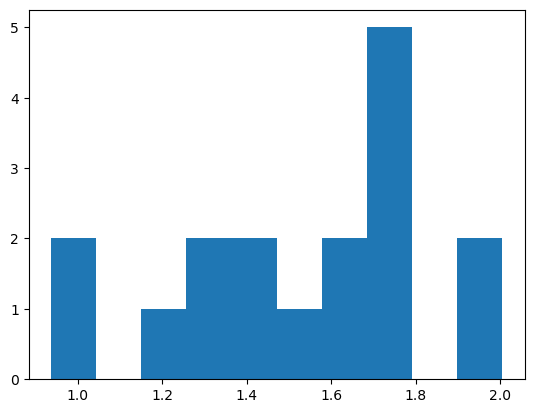

In [57]:
trasnform=lambda x:tanh(x-1)+0.5
plt.hist([x[0] for x in lr_metrics.values()])

(array([2., 0., 1., 0., 2., 2., 2., 6., 0., 2.]),
 array([-0.09432991,  0.01537921,  0.12508833,  0.23479745,  0.34450656,
         0.45421568,  0.5639248 ,  0.67363391,  0.78334303,  0.89305215,
         1.00276127]),
 <BarContainer object of 10 artists>)

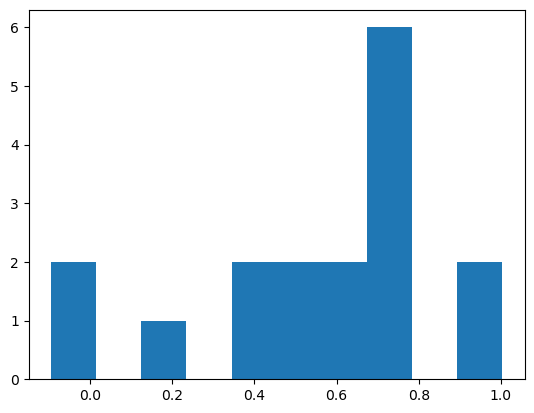

In [58]:
trasnform=lambda x:log2(x)
plt.hist([trasnform(x[0]) for x in lr_metrics.values()])

In [11]:
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap,Normalize,FuncNorm
from math import log
from matplotlib import gridspec

In [12]:
sort_rdrps=parse_diamond(f'{k}_fasta/{ref_accession_dict[k]}-match.tsv')
sort_rdrps.set_index('Subject ID',inplace=True)
sort_rdrps.loc['ZIKV||AY632535']['Percentage of identical matches']

100.0

In [13]:
def sort_genome(genome_names:List[str],sort_rdrps:pd.DataFrame):
    o=[]
    for i in genome_names:
        if i in sort_rdrps.index:
            o.append((i,sort_rdrps.loc[i]['Percentage of identical matches']))
        else:
            o.append((i,0))
    o.sort(key=lambda x:x[1],reverse=True)
    return o

In [31]:

plt.close('all')
sort_rdrps=parse_diamond(f'{k}_fasta/{ref_accession_dict[k]}-match.tsv')
sort_rdrps.set_index('Subject ID',inplace=True)

genomes=domains['genome_name'].unique()



def norm(x_:float):
    # return np.sqrt(x_)
    _pseudo_index=2.4#log(log(1.5,2),0.8)
    _pseudo_identity=2**(x_**_pseudo_index)-1
    return _pseudo_identity
    
def rev_norm(y_:float):
    # return y_**2
    _pseudo_index=2.4#log(log(1.5,2),0.8)
    identity=np.log2(y_+1)**(1/_pseudo_index)
    return identity


In [32]:
fig,ax=plt.subplots(len(genomes)+1,1,sharex=True,figsize=(60,len(genomes)*2))
c=1
# fig,ax=plt.subplots(2,1,sharex=True,figsize=(30,2*2))
gs=gridspec.GridSpec(len(genomes)+1,3)
ax:List[Axes]
for (i,j) in sort_genome(genomes,sort_rdrps):
    '''
    i: genome id,
    j: identity% to ref genome 
    '''
    idf=domains[domains['genome_name']==i]
    # for i,idf in domains.groupby('genome_name'):
        # sequence_length=idf.iloc[0]['genome_length']
    if (idf['domain_accession']==ref_accession_dict[k]).any():
        #TODO better decision of genome length & del_start
        rdrp_start=idf[idf['domain_accession']==ref_accession_dict[k]].iloc[0]['start']
        rdrp_hmm_start=idf[idf['domain_accession']==ref_accession_dict[k]].iloc[0]['hmmStart']
        del_start=ref-(rdrp_start-rdrp_hmm_start*3)
    else:
        del_start=ref-idf.iloc[0]['genome_length']/2
        # print(f'no rdrp warning:{i}') #TODO unified log system
    
    features=[]
    for _,d in idf.iterrows():
        strand=+1 if d['strand']=='SENSE' else -1
        a_=d['domain_annotation'].split(':')[0]
        '''
        a_: simplified description of domain
        #TODO annotated them in a pseudo `GraphicRecord`
        '''
        if d['domain_accession'] in ref_palette:
            identity=identities_dict[d['domain_accession']].get(i,0.2)/100
            _pseudo_identity=norm(identity)
            color=ref_palette[d['domain_accession']](_pseudo_identity)
        else:
            color=missing_palette[d['domain_accession']]
            # print('!')
        # try:
        #     identity=identities_dict[d['domain_accession']][i]
        # except:
        #     identity=0.0
        # try:
        #     palette=ref_palette[]
        # except:
        #     palette=missing_color_map
        # _=identity/100
        # _pseudo_index=log(log(1.5,2),0.8)
        # assert isinstance(2**(_**_pseudo_index)-1,float),f'{_**_pseudo_index}'
        # color=palette(2**(_**_pseudo_index)-1) #
        # if  a_ in dpalette:
        #     color=dpalette[a_]
        # elif a_ in nido_exclusives:
        #     color=nidopalette[nido_exclusives.index(a_)]
        # else:
        #     color='red'
        # color= 'green' if d['domain_accession']=='PF00680' else 'grey'
        features.append(GraphicFeature(start=d['start']+del_start, end=d['end']+del_start, strand=strand, color=color,
                    label=d['domain_accession']))
    record = GraphicRecord(sequence_length=sequence_length, features=features)
    record.plot(ax=ax[c],figure_width=20)
    ax[c].set_facecolor("white")
    ax[c].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) # remove ticks
    ax[c].annotate(i+f'|{j}' ,(-50,-0), xycoords='data', annotation_clip=False, ha='left',fontsize=25) 
    hide_axes(ax[c],0+del_start,idf.iloc[0]['genome_length']+del_start,sequence_length=sequence_length)
    c+=1 # for test 
    # if c==3:
    #     break
    
ax[0].set_axis_off()
fig.tight_layout()

cbar_ax =fig.add_subplot(gs[0,0])
cbar=fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=metric_min,vmax=metric_max), cmap=corr_color_map),cax=cbar_ax,orientation='horizontal')
cbar_tick_locations = [metric_min,1,metric_max]#np.linspace(0,1,4)
cbar.set_ticks(cbar_tick_locations)
cbar.set_ticklabels([f'{i:.1f}' for i in cbar_tick_locations],fontsize=25)
cbar.set_label('Lr `k`',fontsize=30,loc='left')

cbar_ax1 =fig.add_subplot(gs[0,1])
cbar1=fig.colorbar(cm.ScalarMappable(norm=FuncNorm(functions=(norm,rev_norm),vmin=0.,vmax=1.), cmap=ref_palette[ref_accession_dict[k]]),cax=cbar_ax1,orientation='horizontal')
cbar_tick_locations = np.array([0,0.5,0.8,1])
cbar1.set_ticks(cbar_tick_locations)
cbar1.set_ticklabels([f'{i:.1f}' for i in cbar_tick_locations],fontsize=25)
cbar1.set_label('Identity to RefGenome',fontsize=30,loc='center')

cbar_ax2 =fig.add_subplot(gs[0,2])
cbar2=fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0.,vmax=max_missing), cmap=missing_color_map),cax=cbar_ax2,orientation='horizontal')
cbar_tick_locations = np.array(np.linspace(0,max_missing,5))
cbar2.set_ticks(cbar_tick_locations)
cbar2.set_ticklabels([f'{i:.0f}' for i in cbar_tick_locations],fontsize=25)
cbar2.set_label('Missing Gene Freq',fontsize=30,loc='right')

# fig.set_dpi(20)
fig.savefig('xxxx-xxxx.pdf')
# plt.show()
plt.close('all')

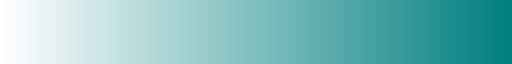

In [170]:
ref_palette[ref_accession_dict[k]]

In [151]:
cm.ScalarMappable(norm=FuncNorm(functions=(norm,rev_norm),vmin=0,vmax=1), cmap=ref_palette[ref_accession_dict[k]])

array([0.00000000e+00, 2.19086364e-07, 1.15634531e-06, 3.05989819e-06,
       6.10324221e-06, 1.04266687e-05, 1.61503452e-05, 2.33806012e-05,
       3.22135260e-05, 4.27372530e-05, 5.50335148e-05, 6.91787590e-05,
       8.52449777e-05, 1.03300346e-04, 1.23409725e-04, 1.45635062e-04,
       1.70035726e-04, 1.96668776e-04, 2.25589195e-04, 2.56850084e-04,
       2.90502828e-04, 3.26597246e-04, 3.65181712e-04, 4.06303272e-04,
       4.50007737e-04, 4.96339773e-04, 5.45342982e-04, 5.97059967e-04,
       6.51532398e-04, 7.08801070e-04, 7.68905955e-04, 8.31886248e-04,
       8.97780413e-04, 9.66626222e-04, 1.03846079e-03, 1.11332061e-03,
       1.19124159e-03, 1.27225908e-03, 1.35640789e-03, 1.44372232e-03,
       1.53423619e-03, 1.62798286e-03, 1.72499526e-03, 1.82530588e-03,
       1.92894682e-03, 2.03594977e-03, 2.14634610e-03, 2.26016678e-03,
       2.37744246e-03, 2.49820347e-03, 2.62247981e-03, 2.75030121e-03,
       2.88169709e-03, 3.01669660e-03, 3.15532862e-03, 3.29762178e-03,
      

In [117]:
missing_palette

{'PF01538': (1.0, 0.7294117647058824, 0.7294117647058824, 1.0),
 'PF07652': (1.0, 0.3058823529411765, 0.3058823529411765, 1.0),
 'PF00998': (1.0, 0.5372549019607843, 0.5372549019607843, 1.0),
 'PF08300': (1.0, 0.7019607843137254, 0.7019607843137254, 1.0),
 'PF01001': (1.0, 0.6745098039215687, 0.6745098039215687, 1.0),
 'PF02907': (1.0, 0.6745098039215687, 0.6745098039215687, 1.0),
 'PF08301': (1.0, 0.7647058823529411, 0.7647058823529411, 1.0),
 'PF12786': (1.0, 0.8784313725490196, 0.8784313725490196, 1.0),
 'PF01506': (1.0, 0.8313725490196078, 0.8313725490196078, 1.0),
 'PF01006': (1.0, 0.803921568627451, 0.803921568627451, 1.0),
 'PF05578': (1.0, 0.8666666666666667, 0.8666666666666667, 1.0),
 'PF11889': (1.0, 0.8784313725490196, 0.8784313725490196, 1.0),
 'PF12387': (1.0, 0.8784313725490196, 0.8784313725490196, 1.0),
 'PF16329': (1.0, 0.8666666666666667, 0.8666666666666667, 1.0),
 'PF05550': (1.0, 0.8784313725490196, 0.8784313725490196, 1.0),
 'PF20907': (1.0, 0.4901960784313726, 0.49

In [106]:
identities_dict[d['domain_accession']]

{'ZIKV||AY632535': 100.0,
 'ZIKV||KY766069': 97.5,
 'ZIKV||KJ776791': 97.5,
 'ZIKV||KX377337': 97.5,
 'ILHV||AY632539': 85.5,
 'NTAV||JX236040': 84.3,
 'BAGV||AY632545': 83.6,
 'SLEV||DQ525916': 84.3,
 'TMUV||JF895923': 83.0,
 'JEV||M18370': 81.8,
 'WNV||M12294': 81.8,
 'KUNV||D00246': 79.1,
 'AROAV||AY632536': 82.4,
 'KOKV||AY632541': 82.5,
 'CPCV||KF917536': 78.6,
 'KEDV||AY632540': 78.5,
 'MVEV||AF161266': 79.2,
 'DENV-1||U88536': 77.9,
 'USUV||AY453411': 77.4,
 'DENV-2||U87411': 77.2,
 'DENV-4||AF326573': 74.8,
 'DENV-3||M93130': 77.4,
 'WESSV||EU707555': 76.1,
 'SEPV||DQ837642': 74.7,
 'KADV||DQ235146': 73.4,
 'JUGV||DQ859066': 71.6,
 'UGSV||DQ859065': 71.5,
 'POTV||DQ859067': 71.6,
 'SABV||DQ859062': 71.0,
 'BOUV||DQ859057': 69.3,
 'POWV||L06436': 71.1,
 'RFV||DQ235149': 71.7,
 'MEAV||DQ235144': 73.2,
 'SREV||DQ235150': 76.4,
 'BANV||DQ859056': 70.3,
 'YFV||X03700': 72.8,
 'DTV||AF311056': 70.4,
 'LGTV||AF253419': 71.7,
 'TBEV-Sib||L40361': 71.1,
 'ENTV||DQ837641': 70.2,
 'YOKV||

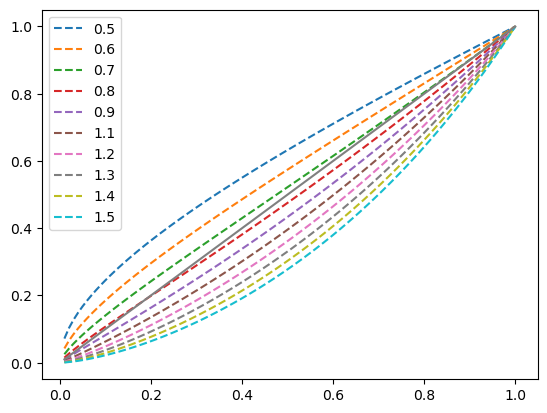

In [13]:
# plt.scatter(*lr_cohort[ref_accession_dict[k]])
x_=lr_metrics[ref_accession_dict[k]][-2]
for i in np.linspace(0.5,1.5,10):
    plt.plot(x_/100,model_function(x_/100,i),'--',label=f'{i:.1f}')
    plt.legend()
plt.plot(x_/100,x_/100,label='x=y',color='grey')

In [55]:
lr_metrics[ref_accession_dict[k]][0]

array([0.75797925])

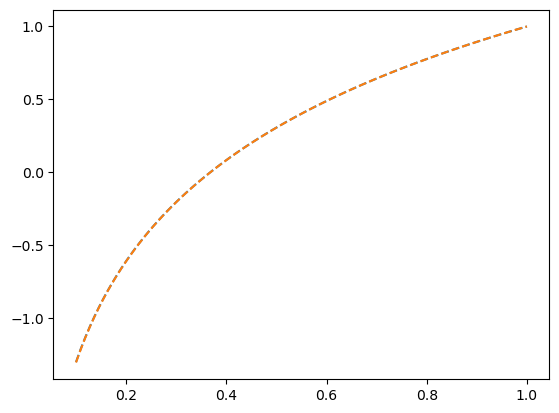

In [33]:
from math import e,log
a=0.001
f=lambda x:x**a/a+1-1/a
x_=np.linspace(10,100,100)
plt.plot(x_/100,f(x_/100),'--',label=f'{i:.1f}')
plt.plot(x_/100,np.log(x_/100)+1,'--',label=f'{i:.1f}')


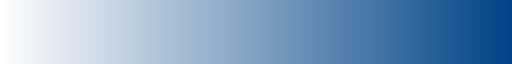

In [97]:
ref_palette[ref_accession_dict[k]]

In [66]:
ref_accession_dict[k]

'PF00972'

In [ ]:
facet

In [14]:
plt.close('all')

In [68]:
ax[c]

<Axes: >

In [61]:
2**(_**_pseudo_index)-1

6.174698332748655e-25j

In [56]:
_pseudo_index

2.4029712352349306

In [55]:
2**(_**_pseudo_index)-1

0.29095804573202555

In [ ]:
plt.colorbar()

In [60]:
identity/100-1e-10

0.6599999999

In [61]:
palette(identity/100-1e-10)

(0.3411764705882353, 0.9948327566320646, 0.6731718569780853, 1.0)

In [57]:
i

'KUNV||D00246'

In [ ]:
# tmp nido palette
coloring = {
 'orf1a': ['bCoV_NSP1', 'CoV_NSP2_N', 'CoV_NSP2_C',
           'bCoV_NSP3_N', 'Macro', 'bCoV_SUD_M', 'bCoV_SUD_C', 
           'CoV_peptidase', 'bCoV_NAR',  'CoV_NSP3_C', 
           'CoV_NSP4_N', 'CoV_NSP4_C', 'Peptidase_C30', 
           'CoV_NSP6', 'CoV_NSP7', 
           'CoV_NSP8', 'CoV_NSP9', 'CoV_NSP10'],
 'rdrp_helicase': [ 'CoV_RPol_N', 'RdRP_1', 'Viral_helicase1'  ],
 'orf1b':         [ 'CoV_Methyltr_1',  'CoV_NSP15_N', 'CoV_NSP15_M',
                    'CoV_NSP15_C', 'CoV_Methyltr_2'],
 '3p_orfs': [       'bCoV_S1_N', 'bCoV_S1_RBD', 'CoV_S1_C',
                    'CoV_S2',  'bCoV_viroporin', 'CoV_E', 'CoV_M', 
                    'bCoV_NS6', 'bCoV_NS7A', 'bCoV_NS7B', 'bCoV_NS8', 
                    'bCoV_lipid_BD', 'CoV_nucleocap','bCoV_Orf14']
}
inv_coloring  = dict([(y,x) for x in coloring for y in coloring[x]])
dpalette = dict()
all_names = set([x for x in inv_coloring])
for region in coloring:
    #region_color = {'orf1a': 'BuPu', 'rdrp_helicase': 'Greens', 'orf1b': 'GnBu', '3p_orfs': 'Greys'}[region]
    #palette = sns.color_palette(region_color, len(coloring[region]) + offset_color)
    region_color, additional_length, offset_color = {'orf1a': ('cubehelix',20,10), 'rdrp_helicase': ('Greens',10,5), 'orf1b': ('BrBG',30,30), '3p_orfs': ('Greys',10,7)}[region]
    palette = sns.color_palette(region_color, len(coloring[region]) + additional_length)
    if region == 'orf1a': palette = palette[::-1]
    for i,name in enumerate(coloring[region]):
        dpalette[name] = palette[offset_color+i] 

# some manual palette fixes
dpalette['Macro'] = "#d42065"
dpalette['Peptidase_C30'] = "#c2da29"
dpalette['RdRP_1'] = "#23d32a"

nido_exclusives=[]
for i in domains['domain_annotation'].apply(lambda x:x.split(':')[0]).unique():
    if i not in dpalette:
        nido_exclusives.append(i)
nidopalette = sns.color_palette('YlGnBu', len(nido_exclusives))